Resnet18 model implementation

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Type, Union, Optional, Callable, List, Any
import numpy as np

In [ ]:

def conv3x3(in_planes: int,
            out_planes: int,
            stride: int = 1,
            groups: int = 1,
            dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


In [ ]:

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self,
                 inplanes: int,
                 planes: int,
                 stride: int = 1,
                 downsample: Optional[nn.Module] = None,
                 groups: int = 1,
                 base_width: int = 64,
                 dilation: int = 1,
                 norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError('Dilation > 1 not supported in BasicBlock')

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.skip_add.add(identity, out)
        out = self.relu2(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu1 = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.skip_add.add(identity, out)
        out = self.relu2(out)

        return out


In [ ]:
class ResNet(nn.Module):
    def __init__(
            self,
            block: Type[Union[BasicBlock, Bottleneck]],
            layers: List[int],
            num_classes: int = 1000,
            zero_init_residual: bool = False,
            groups: int = 1,
            width_per_group: int = 64,
            replace_stride_with_dilation: Optional[List[bool]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(
                replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3,
                               self.inplanes,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight,
                                      0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight,
                                      0)  # type: ignore[arg-type]

    def _make_layer(self,
                    block: Type[Union[BasicBlock, Bottleneck]],
                    planes: int,
                    blocks: int,
                    stride: int = 1,
                    dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, self.groups,
                  self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation,
                      norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
def _resnet(block: Type[Union[BasicBlock, Bottleneck]], layers: List[int], **kwargs: Any) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    return model


def resnet18(**kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [2, 2, 2, 2], **kwargs)



def resnet34(**kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [3, 4, 6, 3], **kwargs)


def resnet50(**kwargs: Any) -> ResNet:
    return _resnet(Bottleneck, [3, 4, 6, 3], **kwargs)

Utilities functions

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [ ]:
plt.style.use('ggplot')

def get_data(batch=64):
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    
    dataset_train = datasets.CIFAR10(
        root='data',
        train=True,
        download=True,
        transform=train_transform
    )

    dataset_valid = datasets.CIFAR10(
        root='data',
        train=False,
        download=True,
        transform=test_transform
    )

    train_sampler = torch.utils.data.RandomSampler(dataset_train)
    test_sampler = torch.utils.data.SequentialSampler(dataset_valid)

    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch,
        sampler=train_sampler
    )

    test_loader = DataLoader(
        dataset=dataset_valid,
        batch_size=batch,
        sampler=test_sampler
    )

    return train_loader, test_loader


def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(f'outputs_{name}_accuracy.png'))

    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', label='validation loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(f'outputs_{name}_loss.png'))


def save_model(model, model_dir, model_filename):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)


def load_model(model, model_filepath, device):
    state_dict = torch.load(model_filepath, map_location=device)
    print(state_dict.keys())
    model.load_state_dict(state_dict)
    return model


def save_torchscript_model(model, model_dir, model_filename):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.jit.save(torch.jit.script(model), model_filepath)


def load_torchscript_model(model_filepath, device):
    model = torch.jit.load(model_filepath, map_location=device)
    return model

In [ ]:
import torch

from tqdm import tqdm


def train(model, trainloader, optimizer, criterion, device):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))

    return epoch_loss, epoch_acc


def validate(model, testloader, criterion, device):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            # Calculate the loss.
            if criterion is not None:
                loss = criterion(outputs, labels).item()
            else:
                loss = 0
            valid_running_loss += loss
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

            # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc


Script to train FP32 model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import random

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)
model_dir = "saved_models"
model_filename = "resnet18_cifar10.pt"
batch_size = 64
learning_rate = 1e-3

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loader, valid_loader = get_data(batch=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model = resnet18(num_classes=10).to(device)
plot_name = 'resnet18_cifar10'

In [ ]:
model = resnet18(num_classes=10).to(device)
model_filepath = os.path.join(model_dir, model_filename)
# model = load_model(model=model, model_filepath=model_filepath, device='cpu')
# save_model(model=model, model_dir=model_dir, model_filename=model_filename)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

11,181,642 total parameters.
11,181,642 training parameters.


In [ ]:
def train_model(model, train_loader, test_loader, device, learning_rate=1e-1, num_epochs=20, plot_name='scratch'):
    # Lists to keep track of losses and accuracies.
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    # Loss function.
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    # Optimizer.
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        print(f"[INFO]: Epoch {epoch + 1} of {num_epochs}")
        train_epoch_loss, train_epoch_acc = train(
            model,
            train_loader,
            optimizer,
            criterion,
            device
        )
        valid_epoch_loss, valid_epoch_acc = validate(
            model,
            test_loader,
            criterion,
            device
        )
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-' * 50)

    # save_model(model, model_dir=model_dir, model_filename=model_filename)
    # Save the loss and accuracy plots.
    save_plots(
        train_acc,
        valid_acc,
        train_loss,
        valid_loss,
        name=plot_name
    )
    print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 10


100%|██████████| 157/157 [00:03<00:00, 41.80it/s]


Training loss: 1.781, training acc: 37.890
Validation loss: 6.005, validation acc: 27.210
--------------------------------------------------
[INFO]: Epoch 2 of 10


100%|██████████| 157/157 [00:04<00:00, 37.15it/s]


Training loss: 1.307, training acc: 52.922
Validation loss: 1.847, validation acc: 51.040
--------------------------------------------------
[INFO]: Epoch 3 of 10


100%|██████████| 157/157 [00:03<00:00, 42.22it/s]


Training loss: 1.118, training acc: 60.600
Validation loss: 1.514, validation acc: 48.670
--------------------------------------------------
[INFO]: Epoch 4 of 10


100%|██████████| 157/157 [00:05<00:00, 28.81it/s]


Training loss: 1.004, training acc: 64.594
Validation loss: 1.549, validation acc: 54.960
--------------------------------------------------
[INFO]: Epoch 5 of 10


100%|██████████| 157/157 [00:04<00:00, 35.37it/s]


Training loss: 0.918, training acc: 67.730
Validation loss: 1.277, validation acc: 61.170
--------------------------------------------------
[INFO]: Epoch 6 of 10


100%|██████████| 157/157 [00:04<00:00, 35.60it/s]


Training loss: 0.863, training acc: 69.728
Validation loss: 1.110, validation acc: 62.620
--------------------------------------------------
[INFO]: Epoch 7 of 10


100%|██████████| 157/157 [00:04<00:00, 36.19it/s]


Training loss: 0.808, training acc: 71.672
Validation loss: 1.240, validation acc: 62.660
--------------------------------------------------
[INFO]: Epoch 8 of 10


100%|██████████| 157/157 [00:04<00:00, 34.21it/s]


Training loss: 0.767, training acc: 73.112
Validation loss: 1.369, validation acc: 56.430
--------------------------------------------------
[INFO]: Epoch 9 of 10


100%|██████████| 157/157 [00:05<00:00, 27.99it/s]


Training loss: 0.732, training acc: 74.370
Validation loss: 0.821, validation acc: 72.150
--------------------------------------------------
[INFO]: Epoch 10 of 10


100%|██████████| 157/157 [00:03<00:00, 41.77it/s]


Training loss: 0.701, training acc: 75.434
Validation loss: 0.740, validation acc: 74.930
--------------------------------------------------
TRAINING COMPLETE


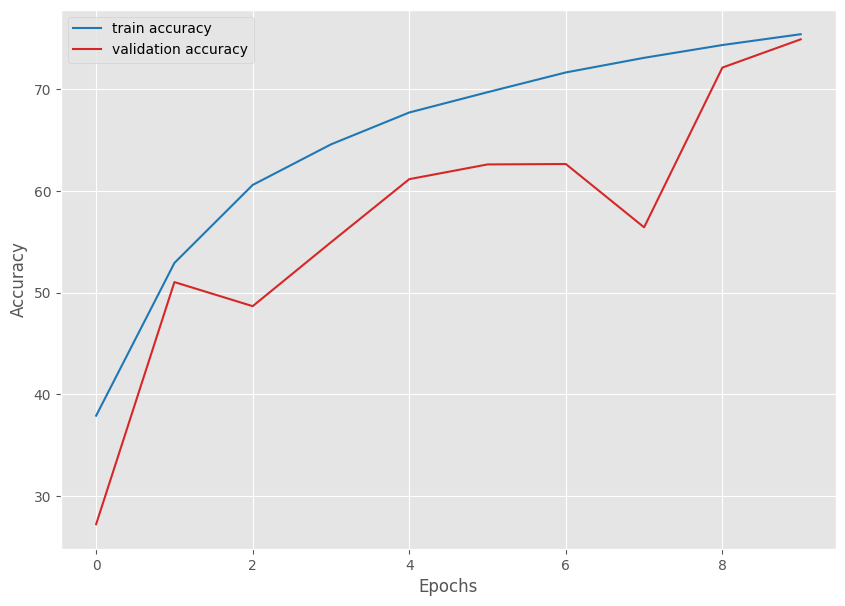

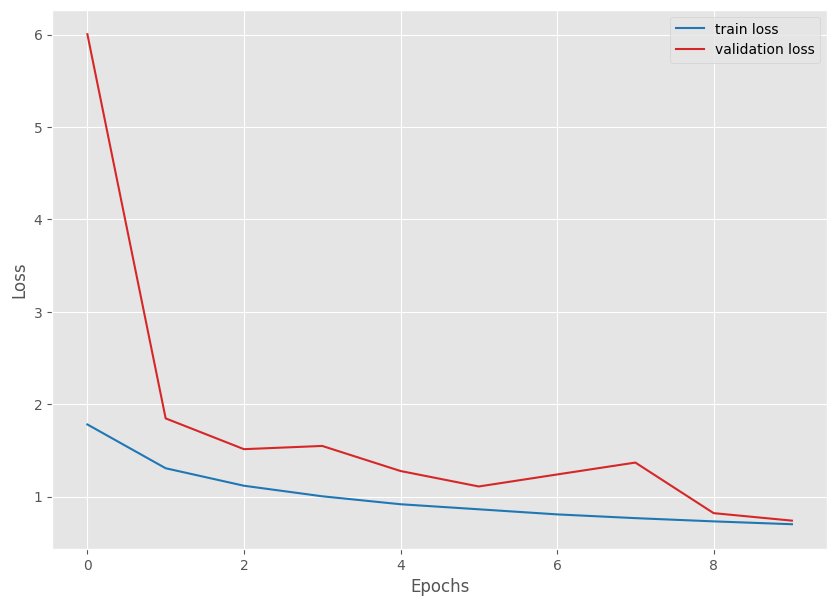

In [ ]:
train_model(model, train_loader, valid_loader, device, num_epochs=10, plot_name=plot_name)

In [ ]:
save_model(model=model, model_dir=model_dir, model_filename=model_filename)

Quantization class for Resnet

In [ ]:
import torch.nn as nn
import torch.quantization
import copy


class QuantizedResNet(nn.Module):
    def __init__(self, model_fp32):
        super(QuantizedResNet, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.model_fp32 = model_fp32

    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = self.dequant(x)
        return x

In [ ]:
def prepare_model_for_quantization(fp32_model, quantized_model_filename, model_dir='saved_models', device='cpu'):
    quantized_model_filepath = os.path.join(model_dir, quantized_model_filename)
    fp32_model.to(device)
    fused_model = copy.deepcopy(fp32_model)
    fused_model.eval()
    fused_model = torch.quantization.fuse_modules(fused_model, [["conv1", "bn1", "relu"]], inplace=True)
    for module_name, module in fused_model.named_children():
        if "layer" in module_name:
            for basic_block_name, basic_block in module.named_children():
                torch.ao.quantization.fuse_modules(basic_block, [["conv1", "bn1", "relu1"], ["conv2", "bn2"]],
                                                inplace=True)
                for sub_block_name, sub_block in basic_block.named_children():
                    if sub_block_name == "downsample":
                        torch.quantization.fuse_modules(sub_block, [["0", "1"]], inplace=True)

    quantized_model = QuantizedResNet(model_fp32=fused_model)
    return quantized_model

In [ ]:
def prepare_resnet50_for_quantization(fp32_model, quantized_model_filename, model_dir='saved_models', device='cpu'):
    quantized_model_filepath = os.path.join(model_dir, quantized_model_filename)
    fp32_model.to(device)
    fused_model = copy.deepcopy(fp32_model)
    fused_model.eval()
    fused_model = torch.quantization.fuse_modules(fused_model, [["conv1", "bn1", "relu"]], inplace=True)
    for module_name, module in fused_model.named_children():
        if "layer" in module_name:
            for basic_block_name, basic_block in module.named_children():
                torch.ao.quantization.fuse_modules(basic_block, [["conv1", "bn1", "relu1"], ["conv2", "bn2"], ["conv3", "bn3"]],
                                                inplace=True)
                for sub_block_name, sub_block in basic_block.named_children():
                    if sub_block_name == "downsample":
                        torch.quantization.fuse_modules(sub_block, [["0", "1"]], inplace=True)

    quantized_model = QuantizedResNet(model_fp32=fused_model)
    return quantized_model

In [ ]:
def perform_qat(quantized_model, train_loader, valid_loader, device='cpu', learning_rate=1e-3, num_epochs=10, plot_name='qat'):
    # Select quantization schemes from
    # https://pytorch.org/docs/stable/quantization-support.html
    quantized_model = copy.deepcopy(quantized_model)
    quantization_config = torch.quantization.get_default_qconfig("fbgemm")
    quantized_model.qconfig = quantization_config
    torch.quantization.prepare_qat(quantized_model, inplace=True)
    print("Training QAT Model...")
    quantized_model.train()
    train_model(quantized_model, train_loader, valid_loader, device,
              learning_rate=learning_rate, num_epochs=num_epochs, plot_name=plot_name)
    quantized_model.to('cpu')
    quantized_model = torch.quantization.convert(quantized_model, inplace=True)
    return quantized_model
  

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

100%|██████████| 157/157 [00:08<00:00, 17.70it/s]


Training loss: 0.583, training acc: 79.576
Validation loss: 0.624, validation acc: 78.660
--------------------------------------------------
[INFO]: Epoch 2 of 10


100%|██████████| 157/157 [00:09<00:00, 17.20it/s]


Training loss: 0.554, training acc: 80.580
Validation loss: 0.621, validation acc: 78.750
--------------------------------------------------
[INFO]: Epoch 3 of 10


100%|██████████| 157/157 [00:08<00:00, 17.52it/s]


Training loss: 0.544, training acc: 80.896
Validation loss: 0.602, validation acc: 79.360
--------------------------------------------------
[INFO]: Epoch 4 of 10


100%|██████████| 157/157 [00:09<00:00, 16.20it/s]


Training loss: 0.535, training acc: 81.278
Validation loss: 0.601, validation acc: 79.560
--------------------------------------------------
[INFO]: Epoch 5 of 10


100%|██████████| 157/157 [00:08<00:00, 17.75it/s]


Training loss: 0.530, training acc: 81.344
Validation loss: 0.602, validation acc: 79.340
--------------------------------------------------
[INFO]: Epoch 6 of 10


100%|██████████| 157/157 [00:10<00:00, 15.38it/s]


Training loss: 0.526, training acc: 81.508
Validation loss: 0.597, validation acc: 79.660
--------------------------------------------------
[INFO]: Epoch 7 of 10


100%|██████████| 157/157 [00:09<00:00, 16.27it/s]


Training loss: 0.522, training acc: 81.598
Validation loss: 0.616, validation acc: 79.120
--------------------------------------------------
[INFO]: Epoch 8 of 10


100%|██████████| 157/157 [00:08<00:00, 17.70it/s]


Training loss: 0.518, training acc: 81.614
Validation loss: 0.602, validation acc: 79.320
--------------------------------------------------
[INFO]: Epoch 9 of 10


100%|██████████| 157/157 [00:09<00:00, 16.91it/s]


Training loss: 0.514, training acc: 81.852
Validation loss: 0.596, validation acc: 79.620
--------------------------------------------------
[INFO]: Epoch 10 of 10


100%|██████████| 157/157 [00:09<00:00, 17.07it/s]


Training loss: 0.511, training acc: 81.964
Validation loss: 0.600, validation acc: 79.650
--------------------------------------------------
TRAINING COMPLETE


QuantizedResNet(
  (quant): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (model_fp32): ResNet(
    (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.07354346662759781, zero_point=0, padding=(3, 3))
    (bn1): Identity()
    (relu): Identity()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.037757594138383865, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu1): Identity()
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07916270196437836, zero_point=67, padding=(1, 1))
        (bn2): Identity()
        (skip_add): QFunctional(
          scale=0.13175919651985168, zero_point=40
          (activation_post_process): Identity()
        )
        (relu2): ReLU(inplace=True

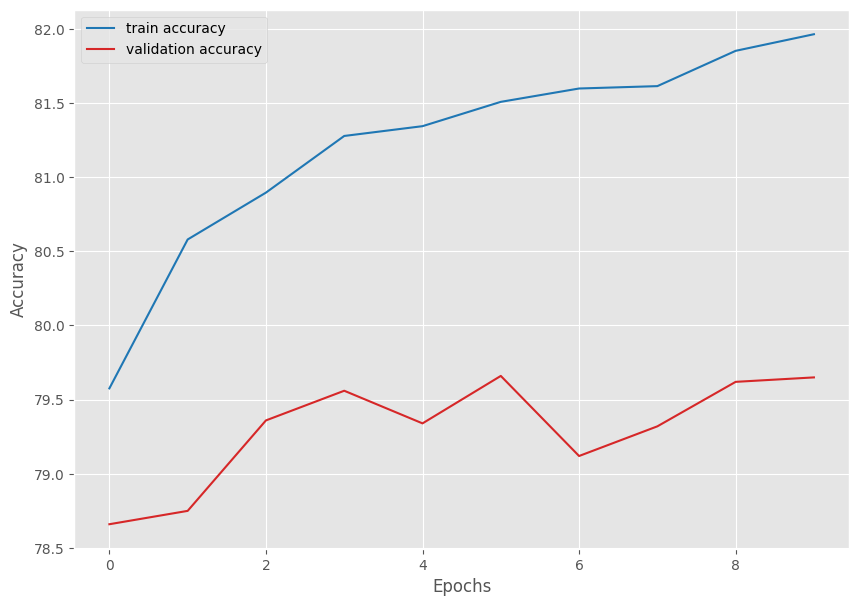

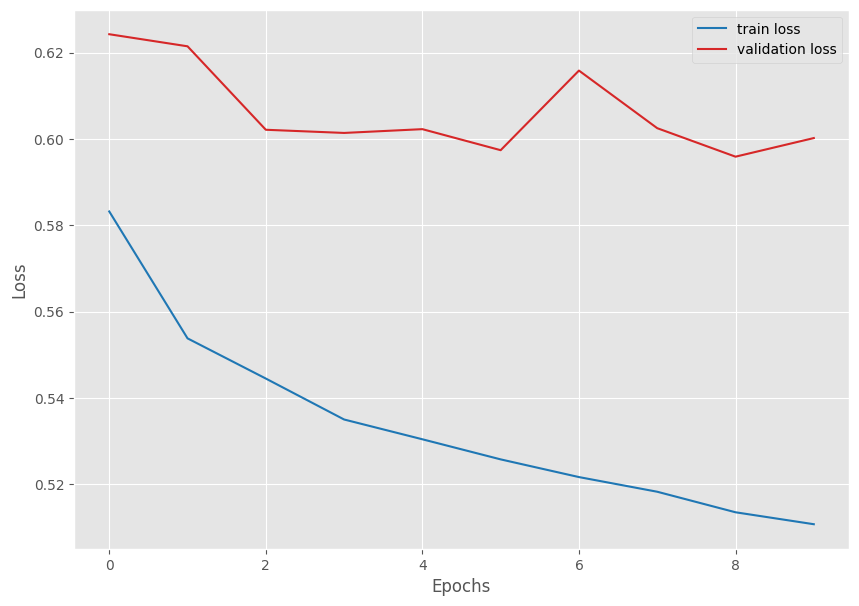

In [ ]:
model = resnet18(num_classes=10).to(device)
model_filepath = os.path.join(model_dir, model_filename)
model = load_model(model=model, model_filepath=model_filepath, device='cpu')
qat_model_filename = "resnet18_qat_cifar10.pt"
qat_model_filepath = os.path.join(model_dir, qat_model_filename)

qat_model = prepare_model_for_quantization(model, qat_model_filename, device=device)
qat_model = perform_qat(qat_model, train_loader, valid_loader, device=device)

qat_model.eval()

In [ ]:
save_model(model=qat_model, model_dir=model_dir, model_filename=qat_model_filename)

In [ ]:
model_jit_filename = "resnet18_jit_cifar10.pt"
save_torchscript_model(model, model_dir, model_jit_filename)
model_filepath_jit = os.path.join(model_dir, model_jit_filename)
jit_model = load_torchscript_model(model_filepath=model_filepath_jit, device='cpu')

In [ ]:
qat_model = prepare_model_for_quantization(model, qat_model_filename, device=device)
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
qat_model.qconfig = quantization_config
torch.quantization.prepare_qat(qat_model, inplace=True)
qat_model.to('cpu')
qat_model = torch.quantization.convert(qat_model, inplace=True)
qat_model = load_model(model=qat_model, model_filepath=qat_model_filepath, device='cpu')
qat_model_jit_filename = "resnet18_qat_jit_cifar10.pt"
save_torchscript_model(qat_model, model_dir, qat_model_jit_filename)

# Load quantized model.
qat_model_filepath_jit = os.path.join(model_dir, qat_model_jit_filename)
qat_jit_model = load_torchscript_model(model_filepath=qat_model_filepath_jit, device='cpu')

/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/observer.py:1209: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


odict_keys(['quant.scale', 'quant.zero_point', 'model_fp32.conv1.weight', 'model_fp32.conv1.bias', 'model_fp32.conv1.scale', 'model_fp32.conv1.zero_point', 'model_fp32.layer1.0.conv1.weight', 'model_fp32.layer1.0.conv1.bias', 'model_fp32.layer1.0.conv1.scale', 'model_fp32.layer1.0.conv1.zero_point', 'model_fp32.layer1.0.conv2.weight', 'model_fp32.layer1.0.conv2.bias', 'model_fp32.layer1.0.conv2.scale', 'model_fp32.layer1.0.conv2.zero_point', 'model_fp32.layer1.0.skip_add.scale', 'model_fp32.layer1.0.skip_add.zero_point', 'model_fp32.layer1.1.conv1.weight', 'model_fp32.layer1.1.conv1.bias', 'model_fp32.layer1.1.conv1.scale', 'model_fp32.layer1.1.conv1.zero_point', 'model_fp32.layer1.1.conv2.weight', 'model_fp32.layer1.1.conv2.bias', 'model_fp32.layer1.1.conv2.scale', 'model_fp32.layer1.1.conv2.zero_point', 'model_fp32.layer1.1.skip_add.scale', 'model_fp32.layer1.1.skip_add.zero_point', 'model_fp32.layer2.0.conv1.weight', 'model_fp32.layer2.0.conv1.bias', 'model_fp32.layer2.0.conv1.scale

In [ ]:
import time
def measure_inference_latency(model,
                              device,
                              input_size=(1, 3, 32, 32),
                              num_samples=100,
                              num_warmups=10):

    model.to(device)
    model.eval()
    x = torch.rand(size=input_size).to(device)

    with torch.no_grad():
        for _ in range(num_warmups):
            _ = model(x)
    torch.cuda.synchronize()
    with torch.no_grad():
        start_time = time.time()
        for _ in range(num_samples):
            _ = model(x)
            torch.cuda.synchronize()
        end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_ave = elapsed_time / num_samples

    return elapsed_time_ave

In [ ]:
def calibrate_model(model, loader, device=torch.device("cpu:0")):

    model.to(device)
    model.eval()

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        _ = model(inputs)

Static quantization

In [ ]:
model = resnet18(num_classes=10).to(device)
model_filepath = os.path.join(model_dir, model_filename)
model = load_model(model=model, model_filepath=model_filepath, device='cpu')
ptq_model_filename = "resnet18_pqt_cifar10.pt"
ptq_model_filepath = os.path.join(model_dir, ptq_model_filename)

ptq_model = prepare_model_for_quantization(model, ptq_model_filename, device=device)
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
ptq_model.qconfig = quantization_config

torch.quantization.prepare(ptq_model, inplace=True)
ptq_model.to('cpu')
ptq_model.eval()
calibrate_model(model=ptq_model, loader=train_loader)
pqt_model = torch.quantization.convert(ptq_model, inplace=True)

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [ ]:
ptq_model_jit_filename = "resnet18_ptq_jit_cifar10.pt"
ptq_model_jit_filepath = os.path.join(model_dir, ptq_model_jit_filename)
# Save quantized model.
save_torchscript_model(model=pqt_model, model_dir=model_dir, model_filename=ptq_model_jit_filename)
save_model(model=pqt_model, model_dir=model_dir, model_filename=ptq_model_filename)

# Load quantized model.
ptq_jit_model = load_torchscript_model(model_filepath=ptq_model_jit_filepath, device='cpu')
ptq_model = load_model(ptq_model, model_filepath=ptq_model_filepath, device='cpu')

odict_keys(['quant.scale', 'quant.zero_point', 'model_fp32.conv1.weight', 'model_fp32.conv1.bias', 'model_fp32.conv1.scale', 'model_fp32.conv1.zero_point', 'model_fp32.layer1.0.conv1.weight', 'model_fp32.layer1.0.conv1.bias', 'model_fp32.layer1.0.conv1.scale', 'model_fp32.layer1.0.conv1.zero_point', 'model_fp32.layer1.0.conv2.weight', 'model_fp32.layer1.0.conv2.bias', 'model_fp32.layer1.0.conv2.scale', 'model_fp32.layer1.0.conv2.zero_point', 'model_fp32.layer1.0.skip_add.scale', 'model_fp32.layer1.0.skip_add.zero_point', 'model_fp32.layer1.1.conv1.weight', 'model_fp32.layer1.1.conv1.bias', 'model_fp32.layer1.1.conv1.scale', 'model_fp32.layer1.1.conv1.zero_point', 'model_fp32.layer1.1.conv2.weight', 'model_fp32.layer1.1.conv2.bias', 'model_fp32.layer1.1.conv2.scale', 'model_fp32.layer1.1.conv2.zero_point', 'model_fp32.layer1.1.skip_add.scale', 'model_fp32.layer1.1.skip_add.zero_point', 'model_fp32.layer2.0.conv1.weight', 'model_fp32.layer2.0.conv1.bias', 'model_fp32.layer2.0.conv1.scale

Gather statistics

In [ ]:
resnet18_inference_latency = measure_inference_latency(model=model, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet18_jit_inference_latency = measure_inference_latency(model=jit_model, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet18_eval_accuracy = validate(model, valid_loader, None, 'cpu')
_, resnet18_jit_eval_accuracy = validate(jit_model, valid_loader, None, 'cpu')
print("Resnet18 Inference Latency: {:.2f} ms / sample".format(resnet18_inference_latency * 1000))
print("Resnet18 JIT Inference Latency: {:.2f} ms / sample".format(resnet18_jit_inference_latency * 1000))

print("Resnet18 evaluation accuracy: {:.3f}".format(resnet18_eval_accuracy))
print("Resnet18 JIT evaluation accuracy: {:.3f}".format(resnet18_jit_eval_accuracy))

100%|██████████| 157/157 [00:25<00:00,  6.18it/s]

Resnet18 Inference Latency: 7.95 ms / sample
Resnet18 JIT Inference Latency: 6.86 ms / sample
Resnet18 evaluation accuracy: 74.930
Resnet18 JIT evaluation accuracy: 74.930


In [ ]:
resnet18_qat_inference_latency = measure_inference_latency(model=qat_model, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet18_qat_jit_inference_latency = measure_inference_latency(model=qat_jit_model, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet18_qat_eval_accuracy = validate(qat_model, valid_loader, None, 'cpu')
_, resnet18_qat_jit_eval_accuracy = validate(qat_jit_model, valid_loader, None, 'cpu')

print("Resnet18 QAT Inference Latency: {:.2f} ms / sample".format(resnet18_qat_inference_latency * 1000))
print("Resnet18 QAT  JIT Inference Latency: {:.2f} ms / sample".format(resnet18_qat_jit_inference_latency * 1000))

print("Resnet18 QAT evaluation accuracy: {:.3f}".format(resnet18_qat_eval_accuracy))
print("Resnet18 QAT JIT evaluation accuracy: {:.3f}".format(resnet18_qat_jit_eval_accuracy))

100%|██████████| 157/157 [00:11<00:00, 14.01it/s]

Resnet18 QAT Inference Latency: 2.80 ms / sample
Resnet18 QAT  JIT Inference Latency: 1.65 ms / sample
Resnet18 QAT evaluation accuracy: 79.530
Resnet18 QAT JIT evaluation accuracy: 79.530


In [ ]:
resnet18_ptq_inference_latency = measure_inference_latency(model=ptq_model, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet18_ptq_jit_inference_latency = measure_inference_latency(model=ptq_jit_model, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet18_ptq_eval_accuracy = validate(ptq_model, valid_loader, None, 'cpu')
_, resnet18_ptq_jit_eval_accuracy = validate(ptq_jit_model, valid_loader, None, 'cpu')

print("Resnet18 PTQ Inference Latency: {:.2f} ms / sample".format(resnet18_ptq_inference_latency * 1000))
print("Resnet18 PTQ  JIT Inference Latency: {:.2f} ms / sample".format(resnet18_ptq_jit_inference_latency * 1000))

print("Resnet18 PTQ evaluation accuracy: {:.3f}".format(resnet18_ptq_eval_accuracy))
print("Resnet18 PTQ JIT evaluation accuracy: {:.3f}".format(resnet18_ptq_jit_eval_accuracy))

100%|██████████| 157/157 [00:11<00:00, 13.69it/s]

Resnet18 PTQ Inference Latency: 2.71 ms / sample
Resnet18 PTQ  JIT Inference Latency: 1.51 ms / sample
Resnet18 PTQ evaluation accuracy: 74.450
Resnet18 PTQ JIT evaluation accuracy: 74.450


In [ ]:
resnet34_filename = "resnet34_cifar10.pt"
resnet34_model = resnet34(num_classes=10).to(device)
plot_name = 'resnet34_cifar10'

[INFO]: Epoch 1 of 10


100%|██████████| 157/157 [00:04<00:00, 36.05it/s]


Training loss: 2.060, training acc: 31.722
Validation loss: 37.856, validation acc: 24.270
--------------------------------------------------
[INFO]: Epoch 2 of 10


100%|██████████| 157/157 [00:04<00:00, 35.02it/s]


Training loss: 1.499, training acc: 46.802
Validation loss: 2.646, validation acc: 43.780
--------------------------------------------------
[INFO]: Epoch 3 of 10


100%|██████████| 157/157 [00:04<00:00, 32.39it/s]


Training loss: 1.272, training acc: 54.966
Validation loss: 6.299, validation acc: 48.600
--------------------------------------------------
[INFO]: Epoch 4 of 10


100%|██████████| 157/157 [00:04<00:00, 36.47it/s]


Training loss: 1.124, training acc: 60.486
Validation loss: 2.300, validation acc: 46.090
--------------------------------------------------
[INFO]: Epoch 5 of 10


100%|██████████| 157/157 [00:04<00:00, 33.96it/s]


Training loss: 1.034, training acc: 63.848
Validation loss: 1.426, validation acc: 56.080
--------------------------------------------------
[INFO]: Epoch 6 of 10


100%|██████████| 157/157 [00:04<00:00, 33.42it/s]


Training loss: 0.981, training acc: 65.394
Validation loss: 3.096, validation acc: 47.510
--------------------------------------------------
[INFO]: Epoch 7 of 10


100%|██████████| 157/157 [00:04<00:00, 37.10it/s]


Training loss: 0.906, training acc: 68.210
Validation loss: 0.869, validation acc: 69.620
--------------------------------------------------
[INFO]: Epoch 8 of 10


100%|██████████| 157/157 [00:05<00:00, 30.84it/s]


Training loss: 0.843, training acc: 70.290
Validation loss: 0.862, validation acc: 69.850
--------------------------------------------------
[INFO]: Epoch 9 of 10


100%|██████████| 157/157 [00:04<00:00, 36.14it/s]


Training loss: 0.797, training acc: 72.074
Validation loss: 3.447, validation acc: 50.720
--------------------------------------------------
[INFO]: Epoch 10 of 10


100%|██████████| 157/157 [00:04<00:00, 35.85it/s]


Training loss: 0.769, training acc: 73.004
Validation loss: 0.959, validation acc: 67.270
--------------------------------------------------
TRAINING COMPLETE


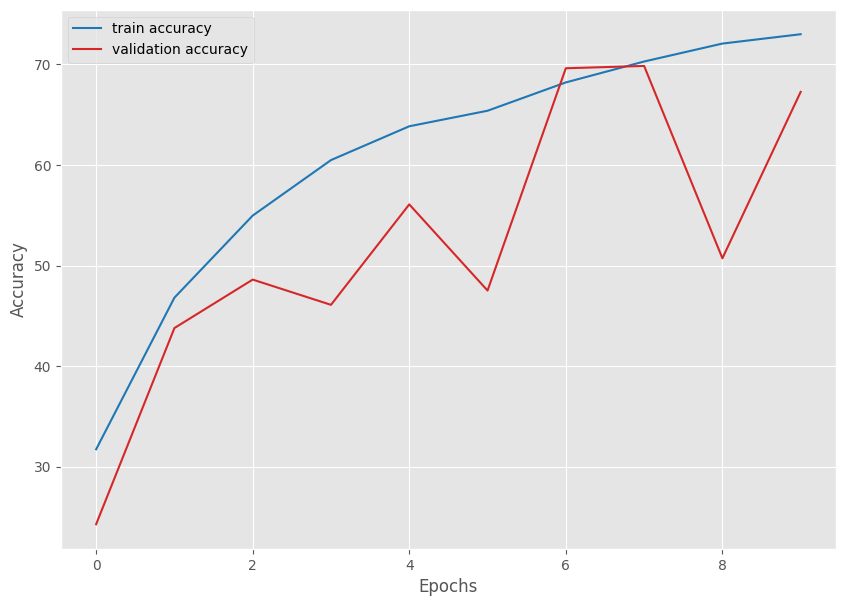

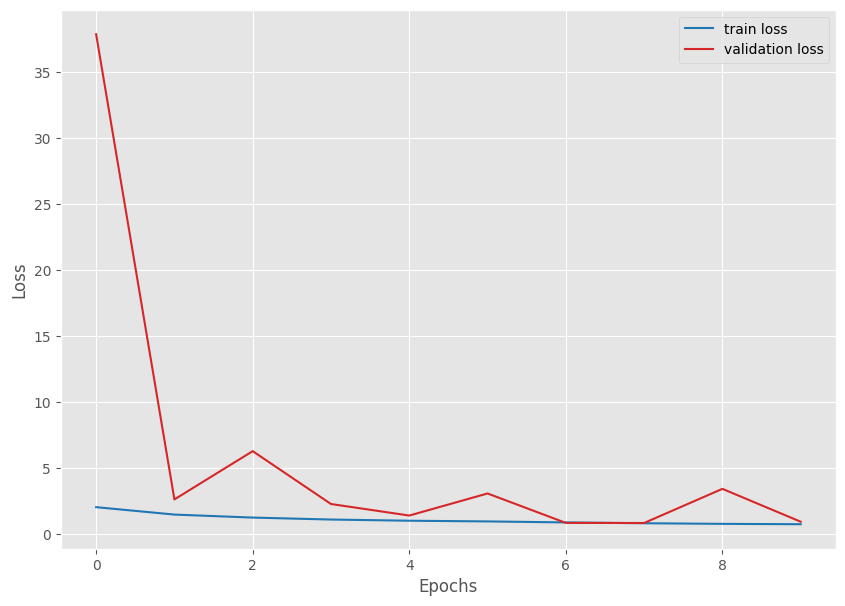

In [ ]:
train_model(resnet34_model, train_loader, valid_loader, device, num_epochs=10, plot_name=plot_name)

In [ ]:
save_model(model=resnet34_model, model_dir=model_dir, model_filename=resnet34_filename)

In [ ]:
resnet34_jit_filename = "resnet34_jit_cifar10.pt"
save_torchscript_model(resnet34_model, model_dir, resnet34_jit_filename)
resnet34_filepath_jit = os.path.join(model_dir, resnet34_jit_filename)
resnet34_jit_model = load_torchscript_model(model_filepath=resnet34_filepath_jit, device='cpu')

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.bn1.num_batches_tracked', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', '

100%|██████████| 157/157 [00:12<00:00, 12.87it/s]


Training loss: 0.742, training acc: 74.228
Validation loss: 0.704, validation acc: 75.900
--------------------------------------------------
[INFO]: Epoch 2 of 10


100%|██████████| 157/157 [00:13<00:00, 11.72it/s]


Training loss: 0.649, training acc: 77.230
Validation loss: 0.677, validation acc: 76.680
--------------------------------------------------
[INFO]: Epoch 3 of 10


100%|██████████| 157/157 [00:14<00:00, 11.16it/s]


Training loss: 0.631, training acc: 77.816
Validation loss: 0.688, validation acc: 76.610
--------------------------------------------------
[INFO]: Epoch 4 of 10


100%|██████████| 157/157 [00:12<00:00, 12.45it/s]


Training loss: 0.622, training acc: 77.944
Validation loss: 0.664, validation acc: 77.200
--------------------------------------------------
[INFO]: Epoch 5 of 10


100%|██████████| 157/157 [00:13<00:00, 11.77it/s]


Training loss: 0.615, training acc: 78.398
Validation loss: 0.662, validation acc: 77.200
--------------------------------------------------
[INFO]: Epoch 6 of 10


100%|██████████| 157/157 [00:13<00:00, 11.88it/s]


Training loss: 0.606, training acc: 78.468
Validation loss: 0.663, validation acc: 77.340
--------------------------------------------------
[INFO]: Epoch 7 of 10


100%|██████████| 157/157 [00:12<00:00, 12.40it/s]


Training loss: 0.606, training acc: 78.646
Validation loss: 0.667, validation acc: 77.450
--------------------------------------------------
[INFO]: Epoch 8 of 10


100%|██████████| 157/157 [00:12<00:00, 12.25it/s]


Training loss: 0.596, training acc: 79.086
Validation loss: 0.697, validation acc: 76.290
--------------------------------------------------
[INFO]: Epoch 9 of 10


100%|██████████| 157/157 [00:13<00:00, 11.55it/s]


Training loss: 0.593, training acc: 79.040
Validation loss: 0.669, validation acc: 77.000
--------------------------------------------------
[INFO]: Epoch 10 of 10


100%|██████████| 157/157 [00:14<00:00, 10.54it/s]


Training loss: 0.596, training acc: 78.994
Validation loss: 0.646, validation acc: 78.270
--------------------------------------------------
TRAINING COMPLETE


QuantizedResNet(
  (quant): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (model_fp32): ResNet(
    (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.09179811924695969, zero_point=0, padding=(3, 3))
    (bn1): Identity()
    (relu): Identity()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.035789888352155685, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu1): Identity()
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07339987903833389, zero_point=67, padding=(1, 1))
        (bn2): Identity()
        (skip_add): QFunctional(
          scale=0.145400732755661, zero_point=34
          (activation_post_process): Identity()
        )
        (relu2): ReLU(inplace=True)


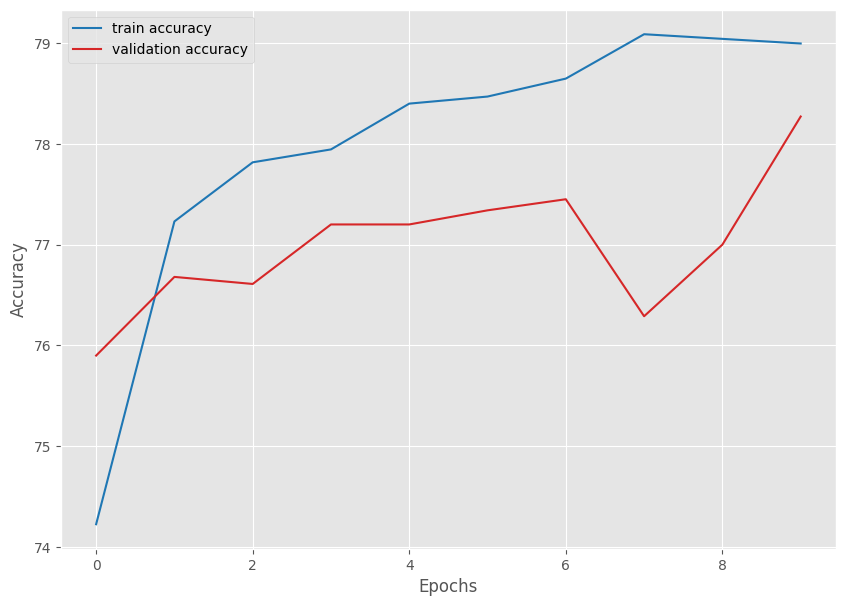

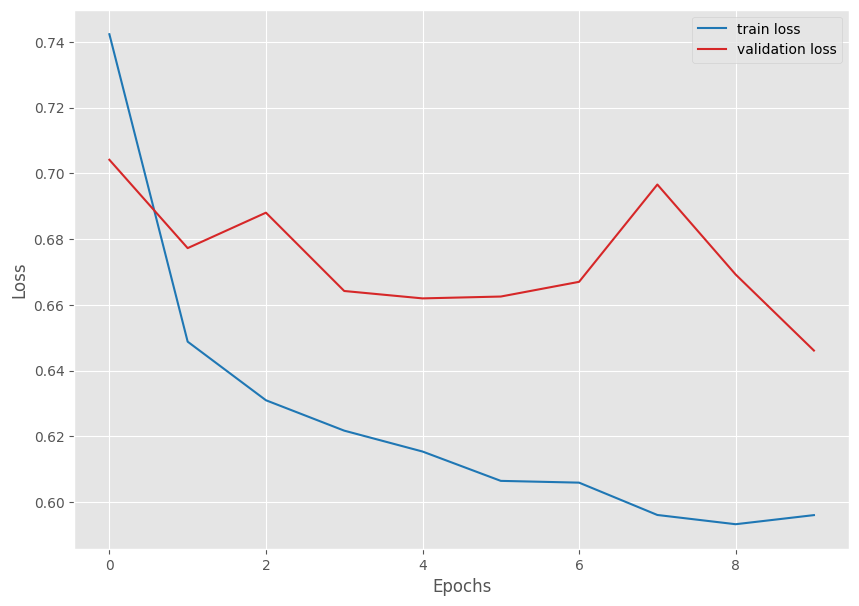

In [ ]:
resnet34_model = resnet34(num_classes=10).to(device)
resnet34_filepath = os.path.join(model_dir, resnet34_filename)
resnet34_model = load_model(model=resnet34_model, model_filepath=resnet34_filepath, device='cpu')
qat_resnet34_filename = "resnet34_qat_cifar10.pt"
qat_resnet34_filepath = os.path.join(model_dir, qat_resnet34_filename)

qat_resnet34 = prepare_model_for_quantization(resnet34_model, qat_resnet34_filename, device=device)
qat_resnet34 = perform_qat(qat_resnet34, train_loader, valid_loader, device=device)

qat_resnet34.eval()

In [ ]:
save_model(model=qat_resnet34, model_dir=model_dir, model_filename=qat_resnet34_filename)

In [ ]:
qat_resnet34 = prepare_model_for_quantization(resnet34_model, qat_resnet34_filename, device=device)
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
qat_resnet34.qconfig = quantization_config
torch.quantization.prepare_qat(qat_resnet34, inplace=True)
qat_resnet34.to('cpu')
qat_resnet34 = torch.quantization.convert(qat_resnet34, inplace=True)
qat_resnet34 = load_model(model=qat_resnet34, model_filepath=qat_resnet34_filepath, device='cpu')

# Save quantized jit model.
qat_resnet34_jit_filename = "resnet34_qat_jit_cifar10.pt"
save_torchscript_model(qat_resnet34, model_dir, qat_resnet34_jit_filename)
# Load quantized jit model.
qat_resnet34_filepath = os.path.join(model_dir, qat_resnet34_filename)
qat_resnet34_filepath_jit = os.path.join(model_dir, qat_resnet34_jit_filename)
qat_resnet34_jit = load_torchscript_model(model_filepath=qat_resnet34_filepath_jit, device='cpu')

odict_keys(['quant.scale', 'quant.zero_point', 'model_fp32.conv1.weight', 'model_fp32.conv1.bias', 'model_fp32.conv1.scale', 'model_fp32.conv1.zero_point', 'model_fp32.layer1.0.conv1.weight', 'model_fp32.layer1.0.conv1.bias', 'model_fp32.layer1.0.conv1.scale', 'model_fp32.layer1.0.conv1.zero_point', 'model_fp32.layer1.0.conv2.weight', 'model_fp32.layer1.0.conv2.bias', 'model_fp32.layer1.0.conv2.scale', 'model_fp32.layer1.0.conv2.zero_point', 'model_fp32.layer1.0.skip_add.scale', 'model_fp32.layer1.0.skip_add.zero_point', 'model_fp32.layer1.1.conv1.weight', 'model_fp32.layer1.1.conv1.bias', 'model_fp32.layer1.1.conv1.scale', 'model_fp32.layer1.1.conv1.zero_point', 'model_fp32.layer1.1.conv2.weight', 'model_fp32.layer1.1.conv2.bias', 'model_fp32.layer1.1.conv2.scale', 'model_fp32.layer1.1.conv2.zero_point', 'model_fp32.layer1.1.skip_add.scale', 'model_fp32.layer1.1.skip_add.zero_point', 'model_fp32.layer1.2.conv1.weight', 'model_fp32.layer1.2.conv1.bias', 'model_fp32.layer1.2.conv1.scale

In [ ]:
resnet34_model = resnet34(num_classes=10).to(device)
resnet34_filepath = os.path.join(model_dir, resnet34_filename)
resnet34_model = load_model(model=resnet34_model, model_filepath=resnet34_filepath, device='cpu')
ptq_resnet34_filename = "resnet34_ptq_cifar10.pt"
ptq_resnet34_filepath = os.path.join(model_dir, ptq_resnet34_filename)

ptq_resnet34 = prepare_model_for_quantization(resnet34_model, ptq_resnet34_filename, device=device)
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
ptq_resnet34.qconfig = quantization_config

torch.quantization.prepare(ptq_resnet34, inplace=True)
ptq_resnet34.to('cpu')
ptq_resnet34.eval()
calibrate_model(model=ptq_resnet34, loader=train_loader)
ptq_resnet34 = torch.quantization.convert(ptq_resnet34, inplace=True)

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.bn1.num_batches_tracked', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', '

/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [ ]:
ptq_resnet34_jit_filename = "resnet34_ptq_jit_cifar10.pt"
ptq_resnet34_jit_filepath = os.path.join(model_dir, ptq_resnet34_jit_filename)
# Save quantized model.
save_torchscript_model(model=ptq_resnet34, model_dir=model_dir, model_filename=ptq_resnet34_jit_filename)
save_model(model=ptq_resnet34, model_dir=model_dir, model_filename=ptq_resnet34_filename)

# Load quantized model.
ptq_resnet34_jit = load_torchscript_model(model_filepath=ptq_resnet34_jit_filepath, device='cpu')
ptq_resnet34 = load_model(ptq_resnet34, model_filepath=ptq_resnet34_filepath, device='cpu')

odict_keys(['quant.scale', 'quant.zero_point', 'model_fp32.conv1.weight', 'model_fp32.conv1.bias', 'model_fp32.conv1.scale', 'model_fp32.conv1.zero_point', 'model_fp32.layer1.0.conv1.weight', 'model_fp32.layer1.0.conv1.bias', 'model_fp32.layer1.0.conv1.scale', 'model_fp32.layer1.0.conv1.zero_point', 'model_fp32.layer1.0.conv2.weight', 'model_fp32.layer1.0.conv2.bias', 'model_fp32.layer1.0.conv2.scale', 'model_fp32.layer1.0.conv2.zero_point', 'model_fp32.layer1.0.skip_add.scale', 'model_fp32.layer1.0.skip_add.zero_point', 'model_fp32.layer1.1.conv1.weight', 'model_fp32.layer1.1.conv1.bias', 'model_fp32.layer1.1.conv1.scale', 'model_fp32.layer1.1.conv1.zero_point', 'model_fp32.layer1.1.conv2.weight', 'model_fp32.layer1.1.conv2.bias', 'model_fp32.layer1.1.conv2.scale', 'model_fp32.layer1.1.conv2.zero_point', 'model_fp32.layer1.1.skip_add.scale', 'model_fp32.layer1.1.skip_add.zero_point', 'model_fp32.layer1.2.conv1.weight', 'model_fp32.layer1.2.conv1.bias', 'model_fp32.layer1.2.conv1.scale

In [ ]:
resnet34_inference_latency = measure_inference_latency(model=resnet34_model, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet34_jit_inference_latency = measure_inference_latency(model=resnet34_jit_model, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet34_eval_accuracy = validate(resnet34_model, valid_loader, None, 'cpu')
_, resnet34_jit_eval_accuracy = validate(resnet34_jit_model, valid_loader, None, 'cpu')
print("Resnet34 Inference Latency: {:.2f} ms / sample".format(resnet34_inference_latency * 1000))
print("Resnet34 JIT Inference Latency: {:.2f} ms / sample".format(resnet34_jit_inference_latency * 1000))

print("Resnet34 evaluation accuracy: {:.3f}".format(resnet34_eval_accuracy))
print("Resnet34 JIT evaluation accuracy: {:.3f}".format(resnet34_eval_accuracy))

100%|██████████| 157/157 [00:44<00:00,  3.56it/s]

Resnet34 Inference Latency: 16.51 ms / sample
Resnet34 JIT Inference Latency: 18.36 ms / sample
Resnet34 evaluation accuracy: 67.270
Resnet34 JIT evaluation accuracy: 67.270


In [ ]:
resnet34_qat_inference_latency = measure_inference_latency(model=qat_resnet34, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet34_qat_jit_inference_latency = measure_inference_latency(model=qat_resnet34_jit, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet34_qat_eval_accuracy = validate(qat_resnet34, valid_loader, None, 'cpu')
_, resnet34_qat_jit_eval_accuracy = validate(qat_resnet34_jit, valid_loader, None, 'cpu')
print("Resnet34 QAT Inference Latency: {:.2f} ms / sample".format(resnet34_qat_inference_latency * 1000))
print("Resnet34 QAT JIT Inference Latency: {:.2f} ms / sample".format(resnet34_qat_jit_inference_latency * 1000))

print("Resnet34 QAT evaluation accuracy: {:.3f}".format(resnet34_qat_eval_accuracy))
print("Resnet34 QAT JIT evaluation accuracy: {:.3f}".format(resnet34_qat_jit_eval_accuracy))

100%|██████████| 157/157 [00:20<00:00,  7.61it/s]

Resnet34 QAT Inference Latency: 8.54 ms / sample
Resnet34 QAT JIT Inference Latency: 4.50 ms / sample
Resnet34 QAT evaluation accuracy: 75.860
Resnet34 QAT JIT evaluation accuracy: 75.860


In [ ]:
resnet34_ptq_inference_latency = measure_inference_latency(model=ptq_resnet34, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet34_ptq_jit_inference_latency = measure_inference_latency(model=ptq_resnet34_jit, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet34_ptq_eval_accuracy = validate(ptq_resnet34, valid_loader, None, 'cpu')
_, resnet34_ptq_jit_eval_accuracy = validate(ptq_resnet34_jit, valid_loader, None, 'cpu')
print("Resnet34 PTQ Inference Latency: {:.2f} ms / sample".format(resnet34_ptq_inference_latency * 1000))
print("Resnet34 PTQ JIT Inference Latency: {:.2f} ms / sample".format(resnet34_ptq_jit_inference_latency * 1000))

print("Resnet34 PTQ evaluation accuracy: {:.3f}".format(resnet34_ptq_eval_accuracy))
print("Resnet34 PTQ JIT evaluation accuracy: {:.3f}".format(resnet34_ptq_jit_eval_accuracy))

100%|██████████| 157/157 [00:20<00:00,  7.66it/s]

Resnet34 PTQ Inference Latency: 5.11 ms / sample
Resnet34 PTQ JIT Inference Latency: 2.75 ms / sample
Resnet34 PTQ evaluation accuracy: 68.040
Resnet34 PTQ JIT evaluation accuracy: 68.040


In [ ]:
resnet50_filename = "resnet50_cifar10.pt"
resnet50_model = resnet50(num_classes=10).to(device)
plot_name = 'resnet50_cifar10'

[INFO]: Epoch 1 of 10


100%|██████████| 157/157 [00:06<00:00, 24.09it/s]


Training loss: 3.302, training acc: 23.842
Validation loss: 16.897, validation acc: 23.300
--------------------------------------------------
[INFO]: Epoch 2 of 10


100%|██████████| 157/157 [00:04<00:00, 34.37it/s]


Training loss: 1.850, training acc: 35.808
Validation loss: 11.149, validation acc: 20.520
--------------------------------------------------
[INFO]: Epoch 3 of 10


100%|██████████| 157/157 [00:05<00:00, 29.10it/s]


Training loss: 1.622, training acc: 42.434
Validation loss: 8.248, validation acc: 39.260
--------------------------------------------------
[INFO]: Epoch 4 of 10


100%|██████████| 157/157 [00:04<00:00, 34.32it/s]


Training loss: 1.501, training acc: 46.366
Validation loss: 20.240, validation acc: 35.490
--------------------------------------------------
[INFO]: Epoch 5 of 10


100%|██████████| 157/157 [00:04<00:00, 34.54it/s]


Training loss: 1.400, training acc: 50.022
Validation loss: 2.730, validation acc: 47.940
--------------------------------------------------
[INFO]: Epoch 6 of 10


100%|██████████| 157/157 [00:06<00:00, 25.51it/s]


Training loss: 1.311, training acc: 53.026
Validation loss: 1.796, validation acc: 39.990
--------------------------------------------------
[INFO]: Epoch 7 of 10


100%|██████████| 157/157 [00:04<00:00, 32.86it/s]


Training loss: 1.249, training acc: 55.598
Validation loss: 3.785, validation acc: 48.610
--------------------------------------------------
[INFO]: Epoch 8 of 10


100%|██████████| 157/157 [00:04<00:00, 35.15it/s]


Training loss: 1.179, training acc: 57.982
Validation loss: 2.382, validation acc: 47.330
--------------------------------------------------
[INFO]: Epoch 9 of 10


100%|██████████| 157/157 [00:05<00:00, 31.05it/s]


Training loss: 1.136, training acc: 59.592
Validation loss: 2.343, validation acc: 55.360
--------------------------------------------------
[INFO]: Epoch 10 of 10


100%|██████████| 157/157 [00:04<00:00, 31.60it/s]


Training loss: 1.065, training acc: 62.038
Validation loss: 3.089, validation acc: 56.220
--------------------------------------------------
TRAINING COMPLETE


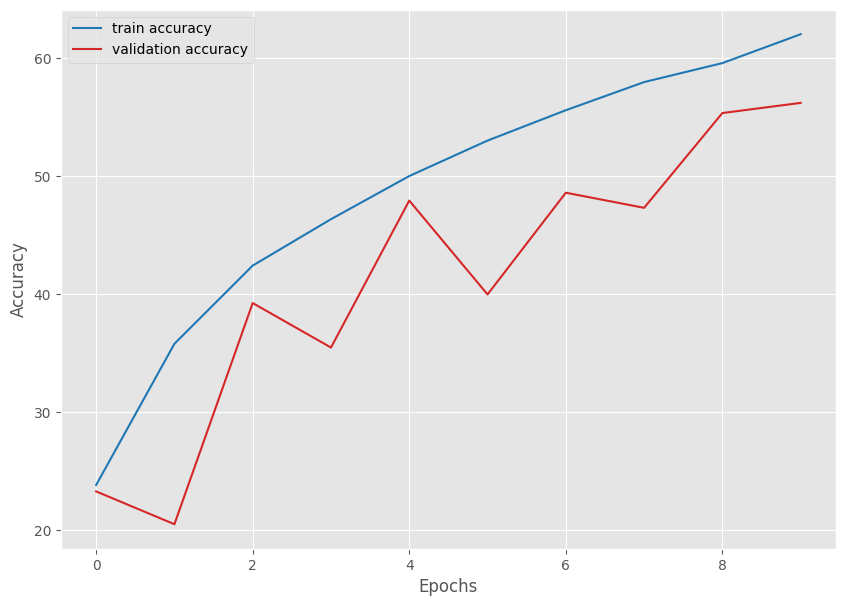

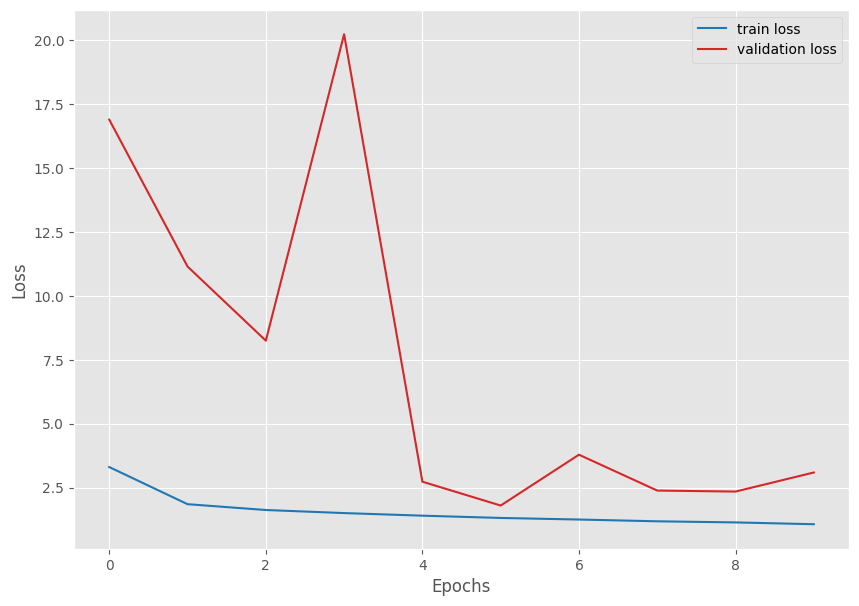

In [ ]:
train_model(resnet50_model, train_loader, valid_loader, device, num_epochs=10, plot_name=plot_name)

In [ ]:
save_model(model=resnet50_model, model_dir=model_dir, model_filename=resnet50_filename)

In [ ]:
resnet50_model = resnet50(num_classes=10).to(device)
resnet50_filepath = os.path.join(model_dir, resnet50_filename)
resnet50_model = load_model(model=resnet50_model, model_filepath=resnet50_filepath, device='cpu')
resnet50_jit_filename = "resnet50_jit_cifar10.pt"
save_torchscript_model(resnet50_model, model_dir, resnet50_jit_filename)
resnet50_filepath_jit = os.path.join(model_dir, resnet50_jit_filename)
resnet50_jit_model = load_torchscript_model(model_filepath=resnet50_filepath_jit, device='cpu')

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

100%|██████████| 157/157 [00:17<00:00,  8.95it/s]


Training loss: 1.055, training acc: 63.184
Validation loss: 0.959, validation acc: 66.000
--------------------------------------------------
[INFO]: Epoch 2 of 10


100%|██████████| 157/157 [00:17<00:00,  8.98it/s]


Training loss: 0.929, training acc: 66.798
Validation loss: 0.915, validation acc: 67.450
--------------------------------------------------
[INFO]: Epoch 3 of 10


100%|██████████| 157/157 [00:17<00:00,  8.83it/s]


Training loss: 0.907, training acc: 67.638
Validation loss: 0.898, validation acc: 67.870
--------------------------------------------------
[INFO]: Epoch 4 of 10


100%|██████████| 157/157 [00:17<00:00,  8.86it/s]


Training loss: 0.886, training acc: 68.436
Validation loss: 0.886, validation acc: 68.730
--------------------------------------------------
[INFO]: Epoch 5 of 10


100%|██████████| 157/157 [00:17<00:00,  8.96it/s]


Training loss: 0.875, training acc: 68.870
Validation loss: 0.868, validation acc: 69.270
--------------------------------------------------
[INFO]: Epoch 6 of 10


100%|██████████| 157/157 [00:17<00:00,  9.04it/s]


Training loss: 0.866, training acc: 69.022
Validation loss: 0.881, validation acc: 68.620
--------------------------------------------------
[INFO]: Epoch 7 of 10


100%|██████████| 157/157 [00:17<00:00,  8.95it/s]


Training loss: 0.855, training acc: 69.378
Validation loss: 0.907, validation acc: 68.220
--------------------------------------------------
[INFO]: Epoch 8 of 10


100%|██████████| 157/157 [00:17<00:00,  8.98it/s]


Training loss: 0.849, training acc: 69.588
Validation loss: 0.860, validation acc: 69.810
--------------------------------------------------
[INFO]: Epoch 9 of 10


100%|██████████| 157/157 [00:17<00:00,  9.06it/s]


Training loss: 0.838, training acc: 70.000
Validation loss: 0.847, validation acc: 70.130
--------------------------------------------------
[INFO]: Epoch 10 of 10


100%|██████████| 157/157 [00:17<00:00,  8.96it/s]


Training loss: 0.834, training acc: 70.196
Validation loss: 0.869, validation acc: 69.360
--------------------------------------------------
TRAINING COMPLETE


QuantizedResNet(
  (quant): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (model_fp32): ResNet(
    (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.061900462955236435, zero_point=0, padding=(3, 3))
    (bn1): Identity()
    (relu): Identity()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.03405023366212845, zero_point=0)
        (bn1): Identity()
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.05764862149953842, zero_point=61, padding=(1, 1))
        (bn2): Identity()
        (conv3): QuantizedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), scale=0.05146532878279686, zero_point=66)
        (bn3): Identity()
        (relu1): Identity()
        (downsample): Sequential(
          (0)

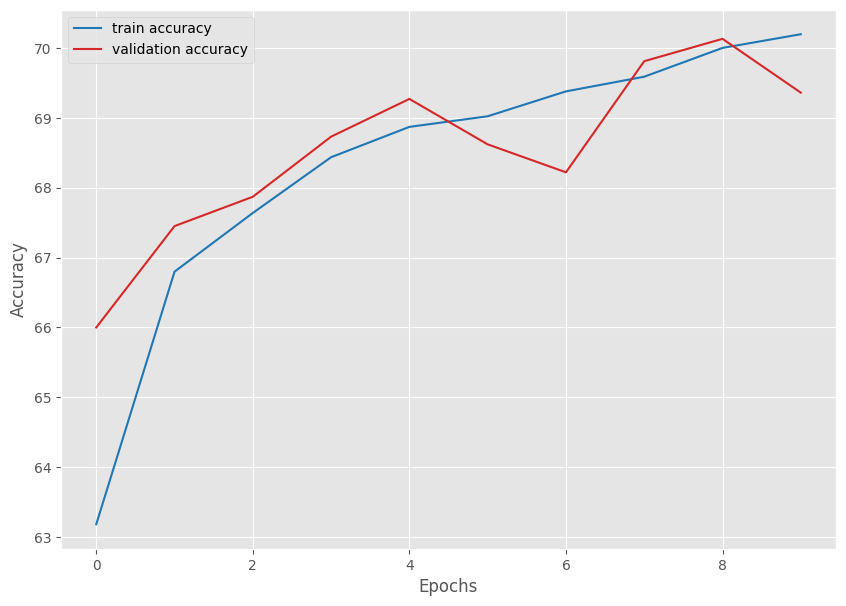

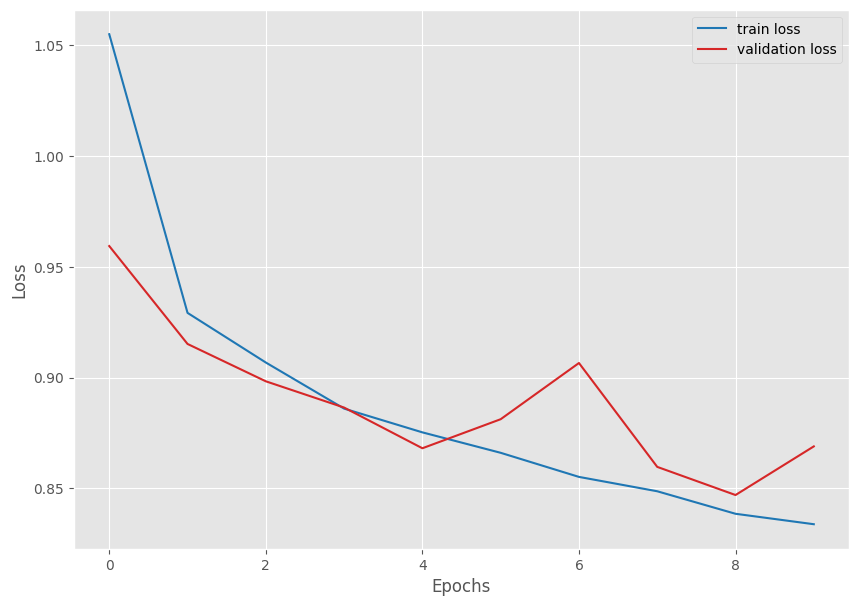

In [ ]:
resnet50_model = resnet50(num_classes=10).to(device)
resnet50_filepath = os.path.join(model_dir, resnet50_filename)
resnet50_model = load_model(model=resnet50_model, model_filepath=resnet50_filepath, device='cpu')
qat_resnet50_filename = "resnet50_qat_cifar10.pt"
qat_resnet50_filepath = os.path.join(model_dir, qat_resnet50_filename)

qat_resnet50 = prepare_resnet50_for_quantization(resnet50_model, qat_resnet50_filename, device=device)
qat_resnet50 = perform_qat(qat_resnet50, train_loader, valid_loader, device=device)

qat_resnet50.eval()

In [ ]:
save_model(model=qat_resnet50, model_dir=model_dir, model_filename=qat_resnet50_filename)

In [ ]:
qat_resnet50_filename = "resnet50_qat_cifar10.pt"
qat_resnet50_filepath = os.path.join(model_dir, qat_resnet50_filename)
qat_resnet50 = prepare_resnet50_for_quantization(resnet50_model, qat_resnet50_filename, device=device)
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
qat_resnet50.qconfig = quantization_config
torch.quantization.prepare_qat(qat_resnet50, inplace=True)
qat_resnet50.to('cpu')
qat_resnet50 = torch.quantization.convert(qat_resnet50, inplace=True)
qat_resnet50 = load_model(model=qat_resnet50, model_filepath=qat_resnet50_filepath, device='cpu')


# Save quantized jit model.
qat_resnet50_jit_filename = "resnet50_qat_jit_cifar10.pt"
save_torchscript_model(qat_resnet50, model_dir, qat_resnet50_jit_filename)
# Load quantized jit model.
qat_resnet50_filepath = os.path.join(model_dir, qat_resnet50_filename)
qat_resnet50_filepath_jit = os.path.join(model_dir, qat_resnet50_jit_filename)
qat_resnet50_jit = load_torchscript_model(model_filepath=qat_resnet50_filepath_jit, device='cpu')

/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/observer.py:1209: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:335: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


odict_keys(['quant.scale', 'quant.zero_point', 'model_fp32.conv1.weight', 'model_fp32.conv1.bias', 'model_fp32.conv1.scale', 'model_fp32.conv1.zero_point', 'model_fp32.layer1.0.conv1.weight', 'model_fp32.layer1.0.conv1.bias', 'model_fp32.layer1.0.conv1.scale', 'model_fp32.layer1.0.conv1.zero_point', 'model_fp32.layer1.0.conv2.weight', 'model_fp32.layer1.0.conv2.bias', 'model_fp32.layer1.0.conv2.scale', 'model_fp32.layer1.0.conv2.zero_point', 'model_fp32.layer1.0.conv3.weight', 'model_fp32.layer1.0.conv3.bias', 'model_fp32.layer1.0.conv3.scale', 'model_fp32.layer1.0.conv3.zero_point', 'model_fp32.layer1.0.downsample.0.weight', 'model_fp32.layer1.0.downsample.0.bias', 'model_fp32.layer1.0.downsample.0.scale', 'model_fp32.layer1.0.downsample.0.zero_point', 'model_fp32.layer1.0.skip_add.scale', 'model_fp32.layer1.0.skip_add.zero_point', 'model_fp32.layer1.1.conv1.weight', 'model_fp32.layer1.1.conv1.bias', 'model_fp32.layer1.1.conv1.scale', 'model_fp32.layer1.1.conv1.zero_point', 'model_fp3

In [ ]:
resnet50_model = resnet50(num_classes=10).to(device)
resnet50_filepath = os.path.join(model_dir, resnet50_filename)
resnet50_model = load_model(model=resnet50_model, model_filepath=resnet50_filepath, device='cpu')

ptq_resnet50_filename = "resnet50_ptq_cifar10.pt"
ptq_resnet50_filepath = os.path.join(model_dir, ptq_resnet50_filename)

ptq_resnet50 = prepare_resnet50_for_quantization(resnet50_model, ptq_resnet50_filename, device=device)
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
ptq_resnet50.qconfig = quantization_config
torch.quantization.prepare(ptq_resnet50, inplace=True)
ptq_resnet50.to('cpu')
ptq_resnet50.eval()
calibrate_model(model=ptq_resnet50, loader=train_loader)
ptq_resnet50 = torch.quantization.convert(ptq_resnet50, inplace=True)

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [ ]:
ptq_resnet50_jit_filename = "resnet50_ptq_jit_cifar10.pt"
ptq_resnet50_jit_filepath = os.path.join(model_dir, ptq_resnet50_jit_filename)
# Save quantized model.
save_torchscript_model(model=ptq_resnet50, model_dir=model_dir, model_filename=ptq_resnet50_jit_filename)
save_model(model=ptq_resnet50, model_dir=model_dir, model_filename=ptq_resnet50_filename)

# Load quantized model.
ptq_resnet50_jit = load_torchscript_model(model_filepath=ptq_resnet50_jit_filepath, device='cpu')
ptq_resnet50 = load_model(ptq_resnet50, model_filepath=ptq_resnet50_filepath, device='cpu')

odict_keys(['quant.scale', 'quant.zero_point', 'model_fp32.conv1.weight', 'model_fp32.conv1.bias', 'model_fp32.conv1.scale', 'model_fp32.conv1.zero_point', 'model_fp32.layer1.0.conv1.weight', 'model_fp32.layer1.0.conv1.bias', 'model_fp32.layer1.0.conv1.scale', 'model_fp32.layer1.0.conv1.zero_point', 'model_fp32.layer1.0.conv2.weight', 'model_fp32.layer1.0.conv2.bias', 'model_fp32.layer1.0.conv2.scale', 'model_fp32.layer1.0.conv2.zero_point', 'model_fp32.layer1.0.conv3.weight', 'model_fp32.layer1.0.conv3.bias', 'model_fp32.layer1.0.conv3.scale', 'model_fp32.layer1.0.conv3.zero_point', 'model_fp32.layer1.0.downsample.0.weight', 'model_fp32.layer1.0.downsample.0.bias', 'model_fp32.layer1.0.downsample.0.scale', 'model_fp32.layer1.0.downsample.0.zero_point', 'model_fp32.layer1.0.skip_add.scale', 'model_fp32.layer1.0.skip_add.zero_point', 'model_fp32.layer1.1.conv1.weight', 'model_fp32.layer1.1.conv1.bias', 'model_fp32.layer1.1.conv1.scale', 'model_fp32.layer1.1.conv1.zero_point', 'model_fp3

In [ ]:
resnet50_inference_latency = measure_inference_latency(model=resnet50_model, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet50_jit_inference_latency = measure_inference_latency(model=resnet50_jit_model, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet50_eval_accuracy = validate(resnet50_model, valid_loader, None, 'cpu')
_, resnet34_jit_eval_accuracy = validate(resnet50_jit_model, valid_loader, None, 'cpu')
print("Resnet50 Inference Latency: {:.2f} ms / sample".format(resnet50_inference_latency * 1000))
print("Resnet50 JIT Inference Latency: {:.2f} ms / sample".format(resnet50_jit_inference_latency * 1000))

print("Resnet50 evaluation accuracy: {:.3f}".format(resnet50_eval_accuracy))
print("Resnet50 JIT evaluation accuracy: {:.3f}".format(resnet50_eval_accuracy))

100%|██████████| 157/157 [00:59<00:00,  2.64it/s]

Resnet50 Inference Latency: 17.86 ms / sample
Resnet50 JIT Inference Latency: 14.51 ms / sample
Resnet50 evaluation accuracy: 56.220
Resnet50 JIT evaluation accuracy: 56.220


In [ ]:
resnet50_qat_inference_latency = measure_inference_latency(model=qat_resnet50, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet50_qat_jit_inference_latency = measure_inference_latency(model=qat_resnet50_jit, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet50_qat_eval_accuracy = validate(qat_resnet50, valid_loader, None, 'cpu')
_, resnet50_qat_jit_eval_accuracy = validate(qat_resnet50_jit, valid_loader, None, 'cpu')
print("Resnet50 QAT Inference Latency: {:.2f} ms / sample".format(resnet50_qat_inference_latency * 1000))
print("Resnet50 QAT JIT Inference Latency: {:.2f} ms / sample".format(resnet50_qat_jit_inference_latency * 1000))

print("Resnet50 QAT evaluation accuracy: {:.3f}".format(resnet50_qat_eval_accuracy))
print("Resnet50 QAT JIT evaluation accuracy: {:.3f}".format(resnet50_qat_jit_eval_accuracy))

100%|██████████| 157/157 [00:23<00:00,  6.76it/s]

Resnet50 QAT Inference Latency: 11.80 ms / sample
Resnet50 QAT JIT Inference Latency: 3.19 ms / sample
Resnet50 QAT evaluation accuracy: 67.840
Resnet50 QAT JIT evaluation accuracy: 67.840


In [ ]:
resnet50_ptq_inference_latency = measure_inference_latency(model=ptq_resnet50, device='cpu', input_size=(1,3,32,32), num_samples=100)
resnet50_ptq_jit_inference_latency = measure_inference_latency(model=ptq_resnet50_jit, device='cpu', input_size=(1,3,32,32), num_samples=100)

_, resnet50_ptq_eval_accuracy = validate(ptq_resnet50, valid_loader, None, 'cpu')
_, resnet50_ptq_jit_eval_accuracy = validate(ptq_resnet50_jit, valid_loader, None, 'cpu')
print("Resnet50 PTQ Inference Latency: {:.2f} ms / sample".format(resnet50_ptq_inference_latency * 1000))
print("Resnet50 PTQ JIT Inference Latency: {:.2f} ms / sample".format(resnet50_ptq_jit_inference_latency * 1000))

print("Resnet50 PTQ evaluation accuracy: {:.3f}".format(resnet50_ptq_eval_accuracy))
print("Resnet50 PTQ JIT evaluation accuracy: {:.3f}".format(resnet50_ptq_jit_eval_accuracy))

100%|██████████| 157/157 [00:22<00:00,  7.14it/s]

Resnet50 PTQ Inference Latency: 8.97 ms / sample
Resnet50 PTQ JIT Inference Latency: 5.45 ms / sample
Resnet50 PTQ evaluation accuracy: 11.290
Resnet50 PTQ JIT evaluation accuracy: 11.290
